# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2024/04/24<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import gc
import warnings
warnings.filterwarnings('ignore')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1731549823.543019   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.563145   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.563186   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
from tensorflow.python.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

I0000 00:00:1731549823.575972   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.576105   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.576133   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.722355   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.722436   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
IMG_WIDTH  = 128
IMG_HEIGHT = 128

## Create a sampling layer

In [6]:
from tensorflow.keras import layers, Sequential, datasets, Model
# Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        config = super().get_config()
        return config

## Build the encoder

In [7]:
latent_dim = 1024
def build_encoder():
    encoder_inputs = keras.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(encoder_inputs)
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (5, 5), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

encoder = build_encoder()
encoder.summary()

I0000 00:00:1731549823.756631   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.756720   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.756737   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.756945   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731549823.756985   56153 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     51,264 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    204,928 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 33,555,456 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 1024)      │  1,049,600 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 1024)      │  1,049,600 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 1024)      │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,911,744 (136.99 MB)

 Trainable params: 35,911,744 (136.99 MB)

 Non-trainable params: 0 (0.00 B)

## Build the decoder

In [8]:
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 128, activation="relu")(latent_inputs)
    x = layers.Reshape((32, 32, 128))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    decoder_outputs = layers.Conv2DTranspose(3, (3,3), activation="relu", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

decoder = build_decoder()
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │   134,348,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,441,923 (512.86 MB)

 Trainable params: 134,441,923 (512.86 MB)

 Non-trainable params: 0 (0.00 B)

## Define the VAE as a `Model` with a custom `train_step`

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train the VAE

In [10]:
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/FYP/models"
history_folder = "/home/dhawi/FYP/History"

In [11]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [12]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 1/1 [00:00<00:00, 24.76it/s]


In [13]:
def train_vae(images):
    encoder = build_encoder()
    decoder = build_decoder()
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    history = vae.fit(images, epochs=150, batch_size=16)
    return history, vae

In [14]:
def save_vae(model_name, vae):
    encoder_path = model_folder + "/" + model_name + "_encoder.h5"
    decoder_path = model_folder + "/" + model_name + "_decoder.h5"
    vae.encoder.save(encoder_path)
    vae.decoder.save(decoder_path)
    vae.save(model_folder + "/" + model_name + ".h5")
    print(model_name, " Model saved")

In [15]:
import matplotlib.pyplot as plt
import json


def show_history(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['reconstruction_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

In [16]:
def show_images(images):
    for i in range(4):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [17]:
def test_vae(images, encoder, decoder):
    predictions = encoder.predict(images)
    predictions = decoder.predict(predictions[2])
    show_images(predictions)

Epoch 1/150


I0000 00:00:1731549827.825398   56237 service.cc:146] XLA service 0x7fc9c40043e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731549827.825440   56237 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - kl_loss: 0.7115 - loss: 55613.9648 - reconstruction_loss: 55613.2539
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - kl_loss: 296.5327 - loss: 35006.7383 - reconstruction_loss: 34710.2070
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 12953.2803 - loss: 32816.4258 - reconstruction_loss: 19863.1445
Epoch 4/150


I0000 00:00:1731549832.665956   56237 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - kl_loss: 1787.8748 - loss: 17092.1582 - reconstruction_loss: 15304.2832
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - kl_loss: 545.1824 - loss: 14250.9443 - reconstruction_loss: 13705.7617
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 258.2543 - loss: 13043.8906 - reconstruction_loss: 12785.6367
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 180.2758 - loss: 12139.6094 - reconstruction_loss: 11959.3340
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - kl_loss: 167.3601 - loss: 11290.3662 - reconstruction_loss: 11123.0059
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - kl_loss: 138.4203 - loss: 11232.5459 - reconstruction_loss: 11094.1260
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - kl_loss: 85.9743 - loss: 10949.8760 - reconstruction_loss: 10863.9014
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - kl_loss: 41.8139 - loss: 10862.8174 - reconstruction_loss: 10821.0039
Epoch 12/150
1/1 ━━━━━━━━━━

fyp_caries_vae1024v2  Model saved


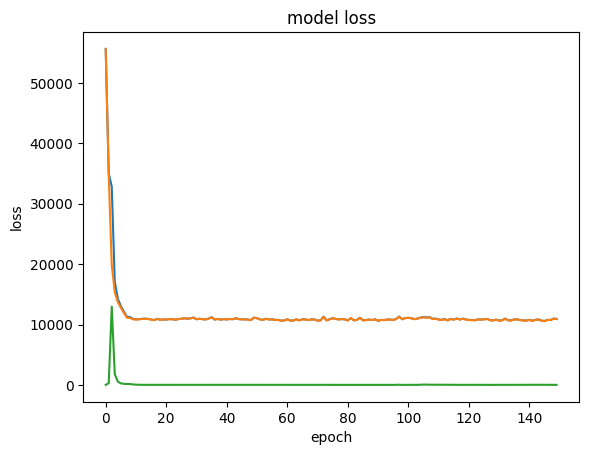

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


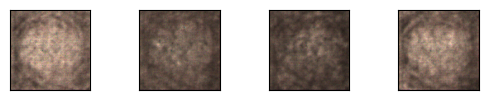

In [18]:
caries_history, caries_vae = train_vae(caries)
save_vae("fyp_caries_vae1024v2", caries_vae)
show_history(caries_history, "caries_vae1024v2")
test_vae(caries, caries_vae.encoder, caries_vae.decoder)
sess.close()
tf.compat.v1.reset_default_graph()

In [19]:
gingivitis_history, gingivitis_vae = train_vae(gingivitis)
save_vae("fyp_gingivitis_vae1024v2", gingivitis_vae)
show_history(gingivitis_history, "noncaries_vae1024v2")
test_vae(gingivitis, gingivitis_vae.encoder, gingivitis_vae.decoder)

Epoch 1/150


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/dhawi/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/dhawi/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/dhawi/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/dhawi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/dhawi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/dhawi/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/dhawi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/dhawi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/dhawi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_56153/848886794.py", line 1, in <module>

  File "/tmp/ipykernel_56153/470884739.py", line 6, in train_vae

  File "/home/dhawi/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/dhawi/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/dhawi/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 553648128 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_16945]

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - kl_loss: 0.1587 - loss: 75673.8906 - reconstruction_loss: 75673.7344
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - kl_loss: 2.8784 - loss: 62634.5938 - reconstruction_loss: 62631.7148
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - kl_loss: 5.2537 - loss: 54030.9688 - reconstruction_loss: 54025.7148
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 5.0620 - loss: 48343.0469 - reconstruction_loss: 48337.9844
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 12.8006 - loss: 44570.3750 - reconstruction_loss: 44557.5742
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 18.3921 - loss: 41676.3203 - reconstruction_loss: 41657.9297
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 17.4595 - loss: 39456.9102 - reconstruction_loss: 39439.4492
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 14.4054 - loss: 37594.5703 - reconstruction_loss: 37580.1641
Epoch 9/150
1/1 ━━━━━━━━━━━━━━

fyp_wsls_vae1024v2  Model saved


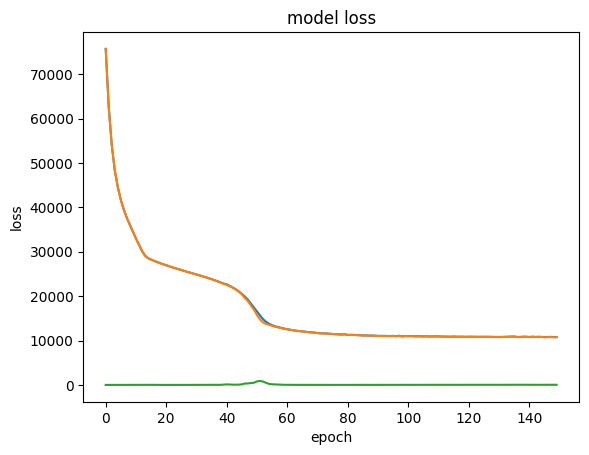

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


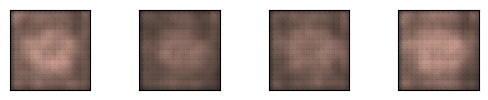

In [ ]:
wsls_history, wsls_vae = train_vae(wsl)
save_vae("fyp_wsls_vae1024v2", wsls_vae)
show_history(wsls_history, "wsls_vae1024v2")
test_vae(wsl, wsls_vae.encoder, wsls_vae.decoder)

In [ ]:
predictions = caries_vae.encoder.predict(caries)
len(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


3